In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes for those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify all patients with left-sided breast cancer, using the following primary site codes:
(C500-506, C508-C509) AND only consider left breast cases: LATERALITY == "Left: origin of primary" coded as 2.
Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation; and the control group, defined as the patients who did not receive any form of radiation. Operationally, these groups are defined by looking at the column RADIATN, which has values:


| Code	| Description |
|:---------:|:--------------:|
|0	| None; diagnosed at autopsy |
|1	|Beam radiation |
|2	|Radioacative implants|
|3	|Radioisotopes|
|4	|Combination of 1 with 2 or 3|
|5	|Radiation, NOS - method or source not specified|
|6	|Other radiation (1973-1987 cases only)|
|7	|Patient or patient's guardian refused radiation therapy|
|8	|Radiation recommened, unknown if administered|
|9	|Unknown if radiation administered|


So that a value of 0 defines the control group, and the values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [3]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\BREAST.txt']

In [4]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

dfbreast0 = seerhelp.make_clean_dataframe(breastfiles[0])
dfbreast1 = seerhelp.make_clean_dataframe(breastfiles[1])
dfbreast2 = seerhelp.make_clean_dataframe(breastfiles[2])
dfbreast3 = seerhelp.make_clean_dataframe(breastfiles[3])

dfbreast = pd.concat([dfbreast0, dfbreast1, dfbreast2,
                     dfbreast3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfbreast.shape)

del dfbreast0
del dfbreast1
del dfbreast2
del dfbreast3

(1448798, 141)


In [5]:
dfbreast.LATERAL.value_counts()

Left origin of primary                                                        730569
Right origin of primary                                                       702454
Paired site, but no information concerning laterality; midline tumor           12729
Only one side involved, right or left origin unspecified                        1667
Bilateral involvement, lateral origin unknown; stated to be single primary      1379
Name: LATERAL, dtype: int64

In [6]:
leftfilter = dfbreast.LATERAL.str.contains('left origin of primary',case=False,na=False)
leftfilter.sum()

730569

In [7]:
mask = (dfbreast['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfbreast['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfbreast['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfbreast['CSTUMSIZ'] != "Not applicable") & \
(dfbreast['AGE_DX'] != "Unknown age") & \
(dfbreast['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfbreast['YEAR_DX'] >= 2004) & \
(dfbreast['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfbreast['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfbreast['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfbreast['CSTUMSIZ'] != "Not applicable") & \
(dfbreast['YR_BRTH'] != 'Unknown year of birth') & \
(dfbreast['CSTUMSIZ'] != 'Not applicable') & \
(dfbreast['CSTUMSIZ'] != 996) & \
(dfbreast['CSTUMSIZ'] != 997) & \
(dfbreast['CSTUMSIZ'] != 998) & \
(dfbreast['REC_NO'] == 1) & \
(leftfilter)

dfbreast = dfbreast[mask]




In [8]:
non_rad = dfbreast.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfbreast.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfbreast.RADIATN.str.contains('Unknown',case=False,na=False)

In [9]:
dfbreastcontrol = dfbreast[non_rad | refused_rad].copy()
dfbreasttreatment = dfbreast[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

In [10]:
print(dfbreastcontrol.shape, dfbreasttreatment.shape)

(125038, 141) (129497, 141)


## <font color='steelblue'>So we are going to match patients in the control group with their nearest neighbors in the treatment group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [11]:
dfbreastcontrol.set_index('PUBCSNUM', inplace=True)
dfbreasttreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfbreastcontrol.index
treatmentindices = dfbreasttreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfbreastcontrol, dfbreasttreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves</font>

In [12]:
resgoodcontrol = pd.concat([pd.get_dummies(dfbreastcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfbreasttreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfbreastcontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfbreastcontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfbreastcontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfbreastcontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfbreastcontrol['lat']
resgoodcontrol['lng'] = dfbreastcontrol['lng']
resgoodcontrol['srv_time_mon'] = dfbreastcontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfbreasttreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfbreasttreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfbreasttreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfbreasttreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfbreasttreatment['lat']
resgoodtreatment['lng'] = dfbreasttreatment['lng']
resgoodtreatment['srv_time_mon'] = dfbreasttreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

### <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and treatment groups together in pairs.

In [13]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All left-sided breast');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 129497 observations, 116669 censored>

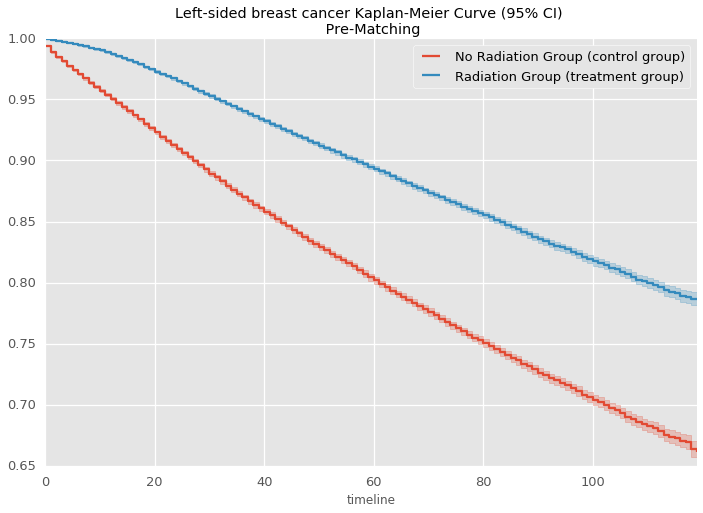

In [14]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Left-sided breast cancer Kaplan-Meier Curve (95% CI) \n Pre-Matching");

## <font color='steelblue'>Clearly, there is a huge benefit to receiving radiation</font>

However, one could logically argue that it is not radiation treatment that is leading to the better survival prognosis, but rather some other feature that leads to better prognosis is also leading to a greater likelihood of receiving radiation therapy. So that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the posistive effects of radiation.

In [15]:
resgoodpop['YR_BRTH'] = resgoodpop['YR_BRTH'].astype('int')
resgoodpop['AGE_DX'] = resgoodpop['AGE_DX'].astype('int')
resgoodpop['CSTUMSIZ'] = resgoodpop['CSTUMSIZ'].astype('float')
resgoodpop['lat'] = resgoodpop['lat'].astype('float')
resgoodpop['lng'] = resgoodpop['lng'].astype('float')
resgoodpop['srv_time_mon'] = resgoodpop['srv_time_mon'].astype('float')

newcolumns = list(resgoodpop.columns)


newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')

resgreatpop = resgoodpop[newcolumns].copy()

In [16]:
resgreatpop['PUBCSNUM'] = resgreatpop.index
leaguefilter = (resgreatpop['PUBCSNUM'].loc[treatmentindices])
resgreatpop['League'] = resgreatpop['PUBCSNUM'].isin(treatmentindices).astype('int')
del resgreatpop['PUBCSNUM']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute force method of finding similar patients characterized by points in a high-dimensional space is possible for this data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more to the distance between patients than **AGE_DX**. the result of standardization (or Z-score normalization) is that features will be rescaled so that they will have the properties of a standard normal distribution with

$
\mu = 0$ and $\sigma = 1$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called z-scores) are then calculated as follows:

$
z_{i} = \frac{x_{i} -\mu}{\sigma}
$

In [18]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.08351446 -0.34425379  0.88890672 ..., -0.44205836  0.84332737
   1.4115178 ]
 [-0.08351446 -0.34425379  0.88890672 ..., -0.39939058  0.85793605
   1.43914214]
 [-0.08351446 -0.34425379 -1.12497744 ..., -0.3567228   0.84332737
   1.4115178 ]
 ..., 
 [-0.08351446 -0.34425379  0.88890672 ..., -0.05804836 -1.51397547
   0.44581432]
 [-0.08351446 -0.34425379  0.88890672 ...,  0.83797497 -1.50646777
   0.63377969]
 [-0.08351446 -0.34425379 -1.12497744 ..., -0.69806502 -1.39163386
   0.6043983 ]]


In [19]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

## <font color='steelblue'>Here is a video explaining the construction of a KDTree</font>

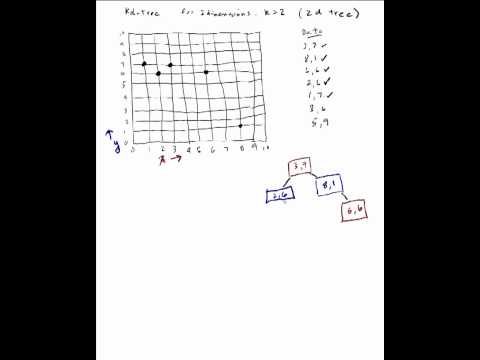

In [20]:
from IPython.display import YouTubeVideo
YouTubeVideo('LdaL-l2S76c')

In [21]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

### <font color='steelblue'>Finding the distances to all of the 4 nearest neighbors for each patient took about one hour. That may sound like a long time, but is nothing compared to a brute force method.

In [22]:

dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [23]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 1)

dist1filter = (dftreeleague['distance_1'] <= .5)
dist2filter = (dftreeleague['distance_2'] <= .5)
dist3filter = (dftreeleague['distance_3'] <= .5)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 1)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 1)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
PUBCSNUM,,,
7006495,93416670,0.449665,1
8361617,93386866,0.489732,1
11734799,92034674,0.172058,1
11735426,11738703,0.313372,1
11735672,11741966,0.301413,1
11735974,11734918,0.056895,1
11736143,11743779,0.335930,1
11736154,92012002,0.456247,1
11737673,92065220,0.314939,1


In [24]:

onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodcontrolteams = list(dd.keys())

goodtreatmentteams = list(dd.values())
matches = list(set([item for sublist in goodtreatmentteams for item in sublist]))

treatmentindices = matches
controlindices = goodcontrolteams
print(len(treatmentindices))
print(len(controlindices))

10000
9521


## <font color='steelblue'>Need to do a one-to-one matching (where each member of the control group is matched to one and only one member of the treatment group, and vice-versa)</font>

In [25]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_c_t = {}

for key, value in d_one_to_one.items():
    if value not in d_c_t.values():
        d_c_t[key] = value
        
controlindices = list(d_c_t.keys())
treatmentindices = list(d_c_t.values())     

In [26]:
controlindices = list(d_c_t.keys())
treatmentindices = list(d_c_t.values())

print(len(controlindices), len(treatmentindices))

8568 8568


So we have 8568 control patients matched very closely (distance less than .5 in the high-dimensional space) to 8568 treatment patients. This is a good-sized group and will allow us to draw definitive statistical inferences.

## <font color='steelblue'>Now here is the Kaplan-Meier plot for the post-matching treatment and control groups</font>



In [27]:
from lifelines import KaplanMeierFitter

#kmfpop = KaplanMeierFitter()
kmfcontrolpost = KaplanMeierFitter()
kmftreatmentpost = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

#kmfpop.fit(Tpop, event_observed=Epop,label='All Nasopharynx');
kmfcontrolpost.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group; post-matching)')
kmftreatmentpost.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group; post-matching)')
#ax = kmfpop.plot()
###ax = kmfcontrol.plot()
###kmftreatment.plot(ax=ax)
###plt.title("Nasopharynx Kaplan-Meier Curve (95% CI) \n Post-Matching");

<lifelines.KaplanMeierFitter: fitted with 8568 observations, 8014 censored>

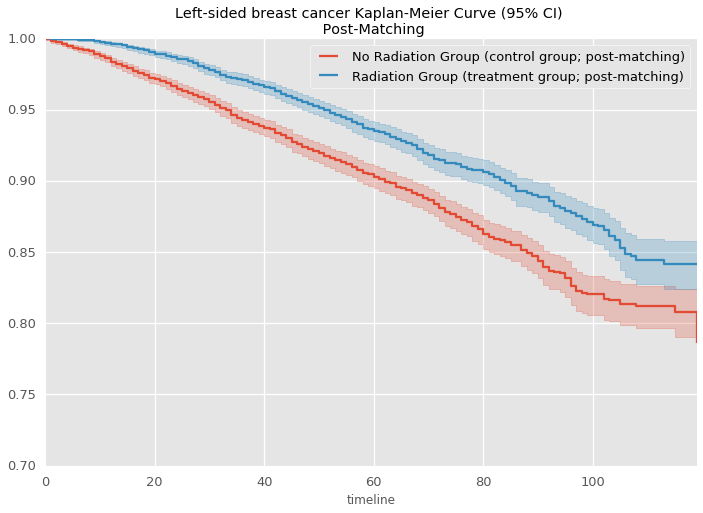

In [28]:
ax = kmfcontrolpost.plot()
kmftreatmentpost.plot(ax=ax)
#kmfcontrol.plot(ax=ax)
#kmftreatment.plot(ax=ax)
plt.title("Left-sided breast cancer Kaplan-Meier Curve (95% CI) \n Post-Matching");

## <font color='steelblue'>We can perform a rigorous test to see if the two survival curves above truly have different "death generation processes."

In [103]:
from lifelines.statistics import logrank_test
results = logrank_test(Ttreatment, Tcontrol, Etreatment, Econtrol)
results.print_summary()

Results
   df: 1
   null distribution: chi squared
   test: logrank
   t 0: -1
   alpha: 0.95

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |             55.326 |      Reject Null    |        True       


## <font color='steelblue'>Because of the matching, the observed differences in the Kaplan-Meier estimates of the survival curves for the control and treatment groups clearly show that there is a real effect and real benefit to having radiation for left-sided breast cancer survival.</font>

### <font color='steelblue'>Now let's perform some paired t-tests to see if there is any demonstrable difference for some characteristics of interest</font>

You may suspect that some of the patients in the control group may have opted out of radiation because they may have already been near the end of life and did not want to go through with the treatment (but our matching should have taken care of and accounted for this possibility; let's see if a t-test based on **AGE_DX** can show that this is **not** the case).

In [29]:
control_age_dx = resgoodpop['AGE_DX'].loc[controlindices]
treatment_age_dx = resgoodpop['AGE_DX'].loc[treatmentindices]
dfage_comp = pd.DataFrame({'control_id': control_age_dx.index,
                          'control_age_dx': control_age_dx.values,
                          'treatment_id': treatment_age_dx.index,
                          'treatment_age_dx':treatment_age_dx.values })
dfage_comp['c_minus_t_age'] = dfage_comp.control_age_dx - dfage_comp.treatment_age_dx

## <font color='steelblue'>Two-sample T-test</font>

A two-sample t-test investigates whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same. 

In [30]:
import scipy.stats as stats
stats.ttest_ind(a=dfage_comp.control_age_dx.as_matrix(), 
               b=dfage_comp.treatment_age_dx.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.051834781232340976, pvalue=0.95866094571478966)

The test yields a p-value of 0.958, which means that there is a 95.8% chance we'd see sample data this far apart if the two groups actually have identical **AGE_DX** distributions. We certaintly cannot reject the null hypothesis; our matching worked and we can guarantee that the differing survival curves for the groups are not influenced by **AGE_DX**.

## <font color='steelblue'>Paired T-Test</font>

The basic two sample t-test is designed for testing differences beween independent groups. In some cases, you might be interested in testing differences between samples of the same group at different points in time. In observational studies like those using the SEER data, the matched pairs in the control and treatment groups are considered for the purposes of paired t-tests to represent the same entity. Let's now see if there is any significant difference in **AGE_DX** between the treatment and control groups using a paired t-test

In [31]:
stats.ttest_rel(a = dfage_comp.control_age_dx.as_matrix(),
                b = dfage_comp.treatment_age_dx.as_matrix())

Ttest_relResult(statistic=0.4125728369528634, pvalue=0.67992992990682377)

## <font color='steelblue'>The paired T-Test also indicates that we actually do not have enough evidence to reject the null hypothesis.</font>

In [32]:
apost = dftreeleague['AGE_DX'][treatmentindices]
bpost = dftreeleague['AGE_DX'][controlindices]

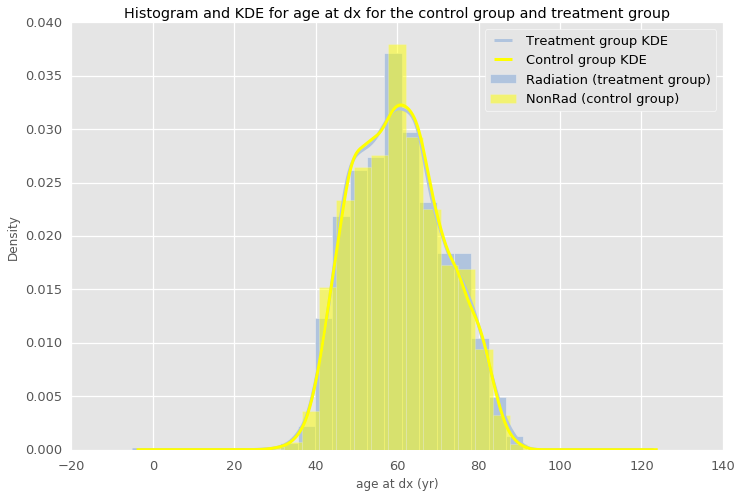

In [33]:

ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for age at dx for the control group and treatment group')
plt.xlabel('age at dx (yr)')
plt.legend();

In [34]:
dfage_comp.control_age_dx.describe()

count    8568.000000
mean       60.562092
std        11.265470
min        27.000000
25%        52.000000
50%        60.000000
75%        68.000000
max        91.000000
Name: control_age_dx, dtype: float64

In [35]:
dfage_comp.treatment_age_dx.describe()

count    8568.000000
mean       60.553221
std        11.135160
min        28.000000
25%        52.000000
50%        60.000000
75%        68.000000
max        92.000000
Name: treatment_age_dx, dtype: float64

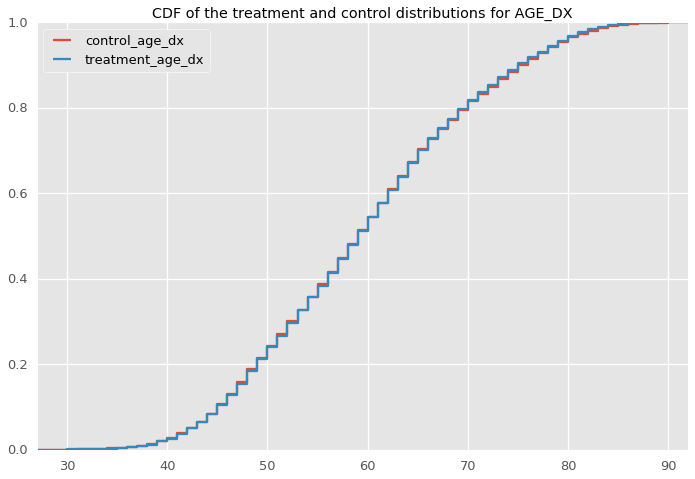

In [36]:
agedxtreatmentcdf = dfage_comp.treatment_age_dx.value_counts(normalize=True).sort_index().cumsum()
agedxcontrolcdf = dfage_comp.control_age_dx.value_counts(normalize=True).sort_index().cumsum()

dfagedx = pd.DataFrame(({'treatment_age_dx': agedxtreatmentcdf,
                        'control_age_dx': agedxcontrolcdf}))

dfagedx = dfagedx.fillna(method='ffill')

dfagedx.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for AGE_DX');

## <font color='steelblue'>Can also quantity the similarity of two distributions using the Kolmogorov-Smirnov test</font>

the k-s test returns a D statistic and a p-value corresponding to the D statistic. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution. 
https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.
The closer the p-value is to 1, the better our matching.

In [37]:
agedxresults = stats.ks_2samp(dfage_comp.treatment_age_dx.as_matrix(),
                             dfage_comp.control_age_dx.as_matrix())
print(agedxresults)

Ks_2sampResult(statistic=0.0049019607843137081, pvalue=0.9999491282808316)


## <font color='steelblue'>Box-and-whiskers plots are especially good for visualizing and comparing two distributions</font>

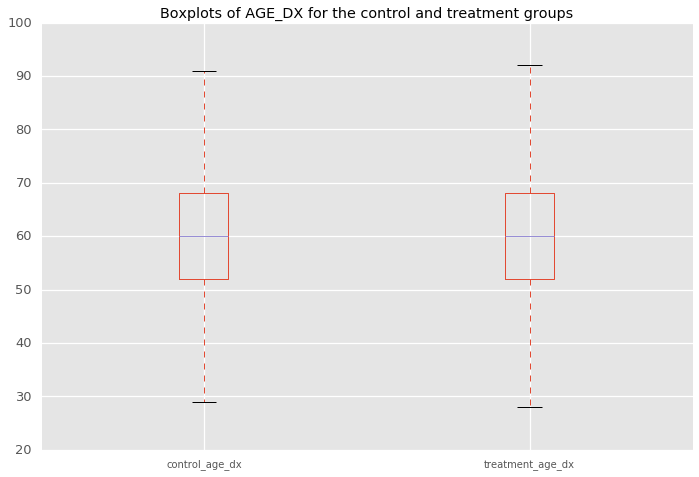

In [38]:
dfage_comp.boxplot(['control_age_dx','treatment_age_dx'],
                  return_type='axes');

plt.title('Boxplots of AGE_DX for the control and treatment groups');

## <font color='steelblue'>Let's check to make sure the distributions for some of the other features used in the matching are close to identifical between for the treatment and control groups</font>

Look at these numerical columns:

* **YR_BRTH**
* **YEAR_DX**
* **CSTUMSIZ**
* **lat**

In [39]:
control_yr_brth = resgoodpop['YR_BRTH'].loc[controlindices]
treatment_yr_brth = resgoodpop['YR_BRTH'].loc[treatmentindices]
dfyob_comp = pd.DataFrame({'control_id': control_yr_brth.index,
                          'control_yr_brth': control_yr_brth.values,
                          'treatment_id': treatment_yr_brth.index,
                          'treatment_yr_brth':treatment_yr_brth.values })
dfyob_comp['c_minus_t_yob'] = dfyob_comp.control_yr_brth - dfyob_comp.treatment_yr_brth


import scipy.stats as stats
stats.ttest_ind(a=dfyob_comp.control_yr_brth.as_matrix(), 
               b=dfyob_comp.treatment_yr_brth.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=-0.036084752109326421, pvalue=0.97121520089604063)

In [40]:
stats.ttest_rel(a = dfyob_comp.control_yr_brth.as_matrix(),
                b = dfyob_comp.treatment_yr_brth.as_matrix())

Ttest_relResult(statistic=-0.29281465739431822, pvalue=0.76967091570281354)

In [41]:
apost = dftreeleague['YR_BRTH'][treatmentindices]
bpost = dftreeleague['YR_BRTH'][controlindices]

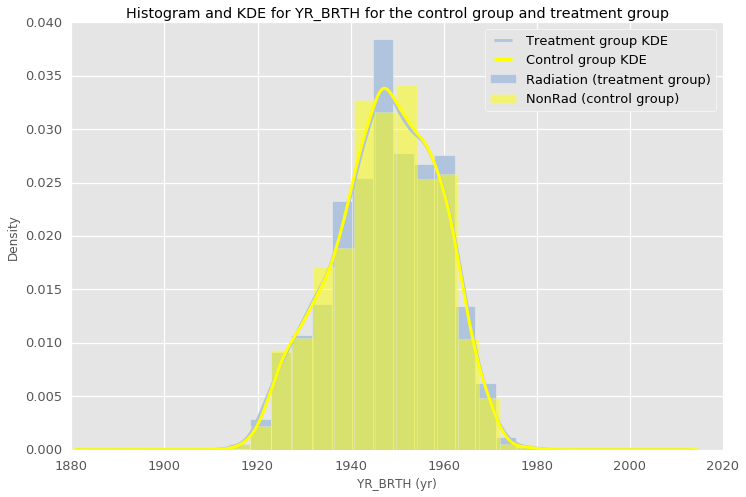

In [42]:
ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for YR_BRTH for the control group and treatment group')
plt.xlabel('YR_BRTH (yr)')
plt.legend();

In [43]:
yobtreatmentcdf = dfyob_comp.treatment_yr_brth.value_counts(normalize=True).sort_index().cumsum()
yobcontrolcdf = dfyob_comp.control_yr_brth.value_counts(normalize=True).sort_index().cumsum()

dfyob = pd.DataFrame(({'treatment_yr_brth': yobtreatmentcdf,
                        'control_yr_brth': yobcontrolcdf}))

dfyob = dfyob.fillna(method='ffill')


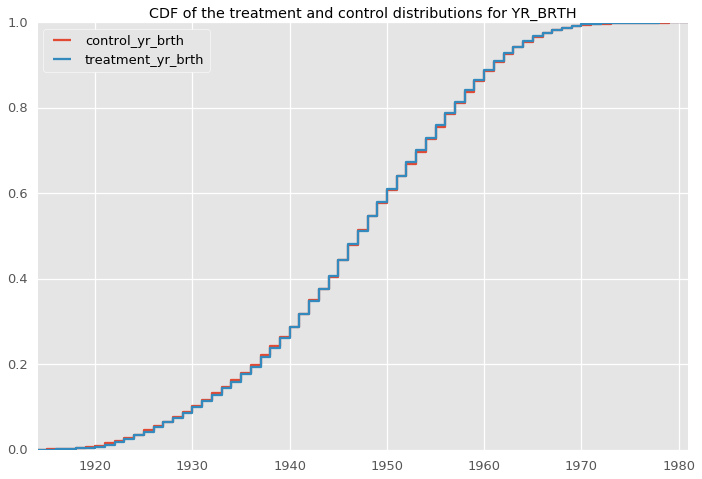

In [44]:


dfyob.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for YR_BRTH');

In [45]:
yobresults = stats.ks_2samp(dfyob_comp.treatment_yr_brth.as_matrix(),
                             dfyob_comp.control_yr_brth.as_matrix())
print(yobresults)

Ks_2sampResult(statistic=0.0056022408963586345, pvalue=0.99926913205016032)


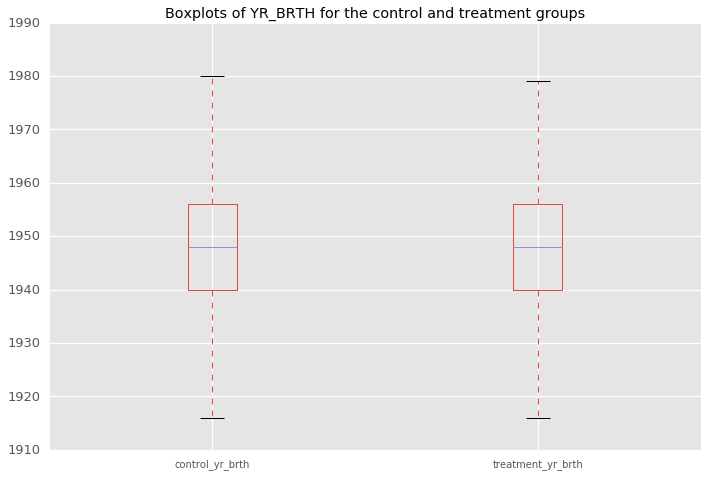

In [46]:
dfyob_comp.boxplot(['control_yr_brth','treatment_yr_brth'],
                  return_type='axes');

plt.title('Boxplots of YR_BRTH for the control and treatment groups');

In [47]:
control_yr_dx = resgoodpop['YEAR_DX'].loc[controlindices]
treatment_yr_dx = resgoodpop['YEAR_DX'].loc[treatmentindices]
dfyrdx_comp = pd.DataFrame({'control_id': control_yr_dx.index,
                          'control_yr_dx': control_yr_dx.values,
                          'treatment_id': treatment_yr_dx.index,
                          'treatment_yr_dx':treatment_yr_dx.values })
dfyrdx_comp['c_minus_t_yrdx'] = dfyrdx_comp.control_yr_dx - dfyrdx_comp.treatment_yr_dx


import scipy.stats as stats
stats.ttest_ind(a=dfyrdx_comp.control_yr_dx.as_matrix(), 
               b=dfyrdx_comp.treatment_yr_dx.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.10722211494435593, pvalue=0.91461402676971049)

In [48]:
stats.ttest_rel(a = dfyrdx_comp.control_yr_dx.as_matrix(),
                b = dfyrdx_comp.treatment_yr_dx.as_matrix())

Ttest_relResult(statistic=0.67289257486474885, pvalue=0.50103378597608506)

In [49]:
apost = dftreeleague['YEAR_DX'][treatmentindices]
bpost = dftreeleague['YEAR_DX'][controlindices]

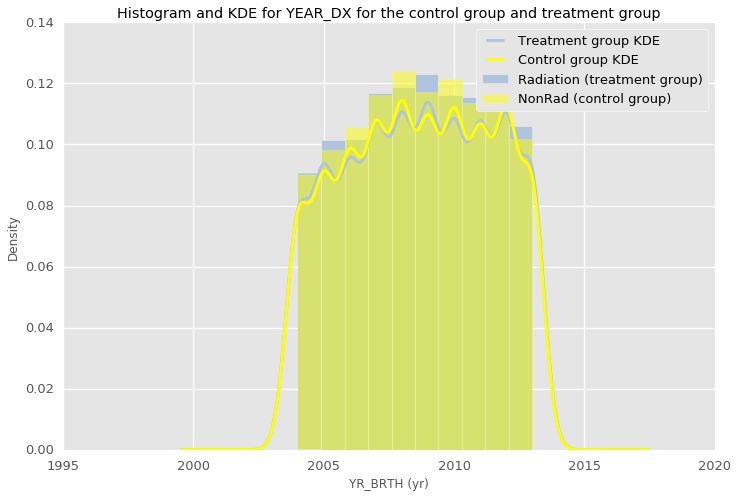

In [50]:
ax = bpost.hist(bins=10,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=10,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for YEAR_DX for the control group and treatment group')
plt.xlabel('YR_BRTH (yr)')
plt.legend();

In [51]:
yrdxtreatmentcdf = dfyrdx_comp.treatment_yr_dx.value_counts(normalize=True).sort_index().cumsum()
yrdxcontrolcdf = dfyrdx_comp.control_yr_dx.value_counts(normalize=True).sort_index().cumsum()

dfyrdx = pd.DataFrame(({'treatment_yr_dx': yrdxtreatmentcdf,
                        'control_yr_dx': yrdxcontrolcdf}))

dfyrdx = dfyrdx.fillna(method='ffill')

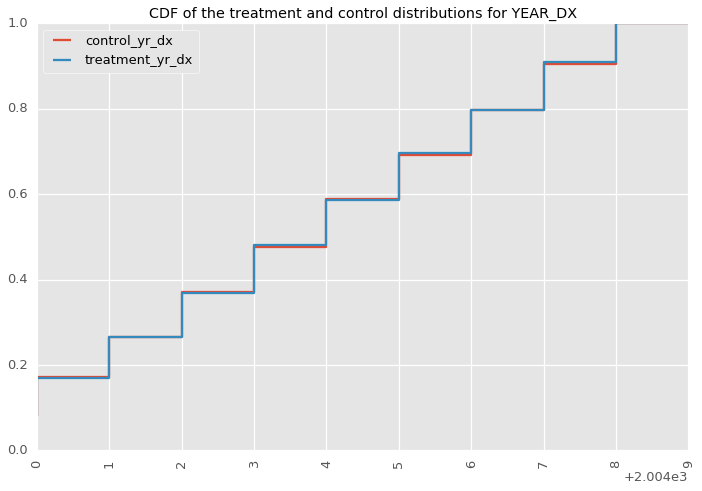

In [52]:
dfyrdx.plot(drawstyle='steps',
            title='CDF of the treatment and control distributions for YEAR_DX',rot=90);

In [53]:
yrdxresults = stats.ks_2samp(dfyrdx_comp.treatment_yr_dx.as_matrix(),
                             dfyrdx_comp.control_yr_dx.as_matrix())
print(yrdxresults)

Ks_2sampResult(statistic=0.0038515406162464849, pvalue=0.99999996045867323)


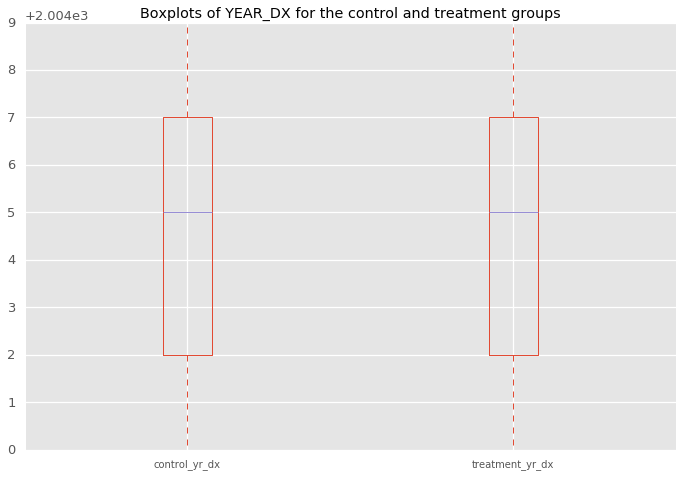

In [54]:

dfyrdx_comp.boxplot(['control_yr_dx','treatment_yr_dx'],
                  return_type='axes');

plt.title('Boxplots of YEAR_DX for the control and treatment groups');

In [55]:
apost = dftreeleague['CSTUMSIZ'][treatmentindices]
bpost = dftreeleague['CSTUMSIZ'][controlindices]

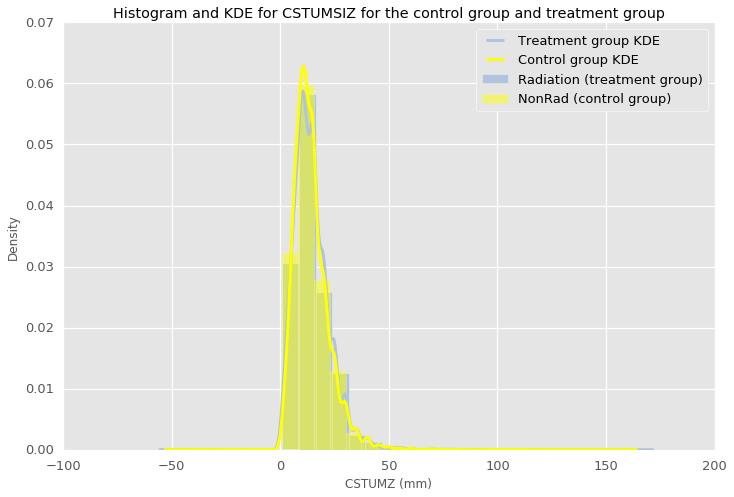

In [56]:
ax = bpost.hist(bins=15,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=15,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for CSTUMSIZ for the control group and treatment group')
plt.xlabel('CSTUMZ (mm)')
plt.legend();

## <font color='steelblue'>The histograms and KDE approximations for the CSTUMSIZ distributions also look very similar</font>

But the CDF and the Kolmogorov-Smirnov test tell a different story. What's going on?

In [57]:
treatmenttum = dftreeleague['CSTUMSIZ'][treatmentindices]
controltum = dftreeleague['CSTUMSIZ'][controlindices]

treatmenttumcdf = treatmenttum.value_counts(normalize=True).sort_index().cumsum()
controltumcdf = controltum.value_counts(normalize=True).sort_index().cumsum()

dftum = pd.DataFrame({'treatment_tumsize': treatmenttumcdf,
                     'control_tumsize': controltumcdf})

dftum = dftum.fillna(method='ffill')


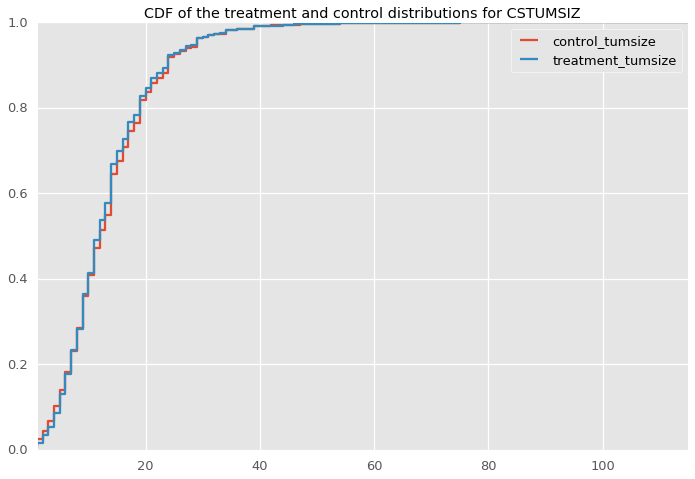

In [58]:
dftum.plot(drawstyle='steps',
          title='CDF of the treatment and control distributions for CSTUMSIZ');


In [59]:
tumresults = stats.ks_2samp(treatmenttum.as_matrix(),
                             controltum.as_matrix())
print(tumresults)


Ks_2sampResult(statistic=0.027777777777777679, pvalue=0.00262527961005977)


## <font color='steelblue'>The problem with CSTUMSIZ is the data itself...rounding up to numbers that end in 5 or 0!</font>

If we plot bar charts of the distributions, you can clearly see the reporting bias towards these round numbers. The CSTUMSIZ variable is clearly clumped around the 5mm increments. I would not have expected this kind of rounding in a cancer registry, but there it is clear as day.

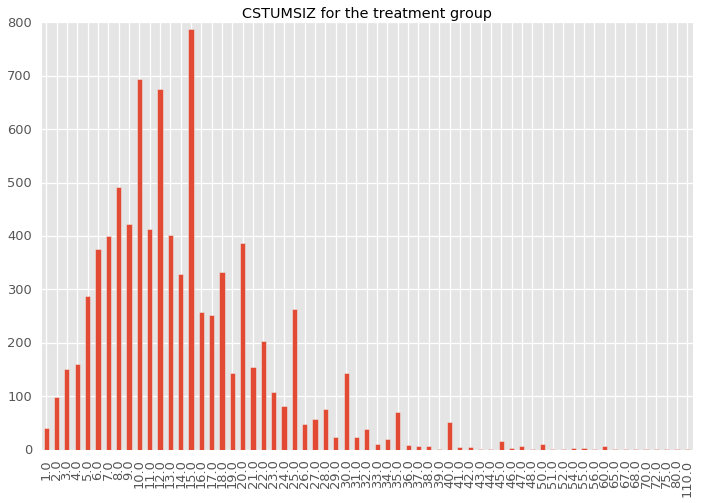

In [60]:
treatmenttum.value_counts().sort_index().plot(kind='bar',
    title='CSTUMSIZ for the treatment group');

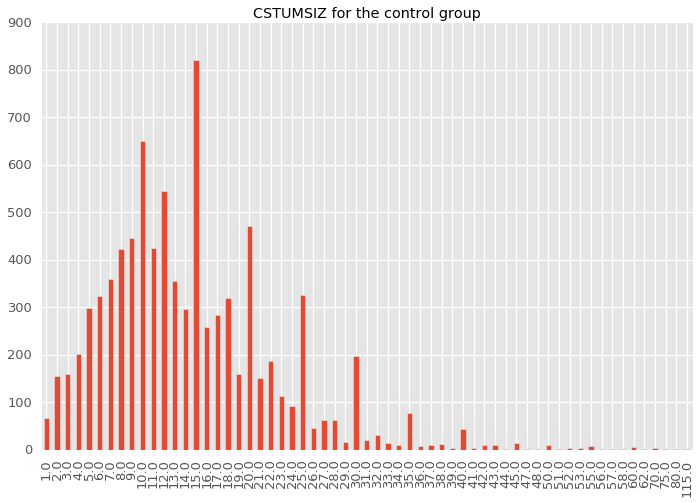

In [61]:
controltum.value_counts().sort_index().plot(kind='bar',
    title='CSTUMSIZ for the control group');

In [62]:
control_cstumsiz = resgoodpop['CSTUMSIZ'].loc[controlindices]
treatment_cstumsiz = resgoodpop['CSTUMSIZ'].loc[treatmentindices]
dfcstumsiz_comp = pd.DataFrame({'control_id': control_cstumsiz.index,
                          'control_cstumsiz': control_cstumsiz.values,
                          'treatment_id': treatment_cstumsiz.index,
                          'treatment_cstumsiz':treatment_cstumsiz.values })
dfcstumsiz_comp['c_minus_t_cstumsiz'] = dfcstumsiz_comp.control_cstumsiz - dfcstumsiz_comp.treatment_cstumsiz

## <font color='steelblue'>And the box plots for CSTUMSIZ visually show the coarse-grained agreement</font>

* The K-S test is very sensitive to granularity. The CSTUMSIZ data suffers from systematic plus the usual random measurement uncertaintly. AGE_DX, YEAR_BRTH, etc. suffer from **zero** measurement uncertaintly.

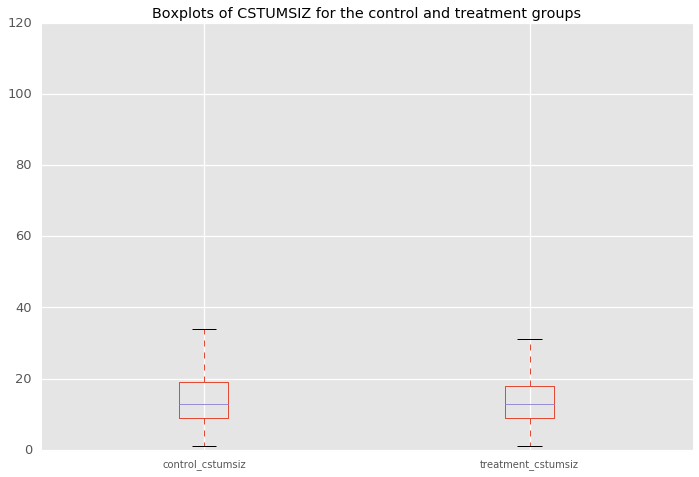

In [63]:
dfcstumsiz_comp.boxplot(['control_cstumsiz','treatment_cstumsiz'],
                  return_type='axes');

plt.title('Boxplots of CSTUMSIZ for the control and treatment groups');

In [64]:
dfcstumsiz_comp[['control_cstumsiz','treatment_cstumsiz']].describe()

,control_cstumsiz,treatment_cstumsiz
count,8568.000000,8568.000000
mean,14.491597,14.301004
std,8.340312,8.139345
min,1.000000,1.000000
25%,9.000000,9.000000
50%,13.000000,13.000000
75%,19.000000,18.000000
max,115.000000,110.000000


In [65]:
control_lat = resgoodpop['lat'].loc[controlindices]
treatment_lat = resgoodpop['lat'].loc[treatmentindices]
dflat_comp = pd.DataFrame({'control_id': control_lat.index,
                          'control_lat': control_lat.values,
                          'treatment_id': treatment_lat.index,
                          'treatment_lat':treatment_lat.values })
dflat_comp['c_minus_t_lat'] = dflat_comp.control_lat - dflat_comp.treatment_lat


import scipy.stats as stats
stats.ttest_ind(a=dflat_comp.control_lat.as_matrix(), 
               b=dflat_comp.treatment_lat.as_matrix(),
               equal_var=False)   # assume samples have equal variance?

Ttest_indResult(statistic=0.09697779633238407, pvalue=0.92274516154658204)

In [66]:
stats.ttest_rel(a = dflat_comp.control_lat.as_matrix(),
                b = dflat_comp.treatment_lat.as_matrix())

Ttest_relResult(statistic=0.78852476626175205, pvalue=0.43041163664891569)

In [67]:
apost = dftreeleague['lat'][treatmentindices]
bpost = dftreeleague['lat'][controlindices]

## <font color='steelblue'>The latitude is obtained from the STATE and COUNTY FIPS codes and the google maps API</font>

The SEER registries do not cover the entire United States and are limited to certain regions; hence the funny looking distributions for lat shown next.

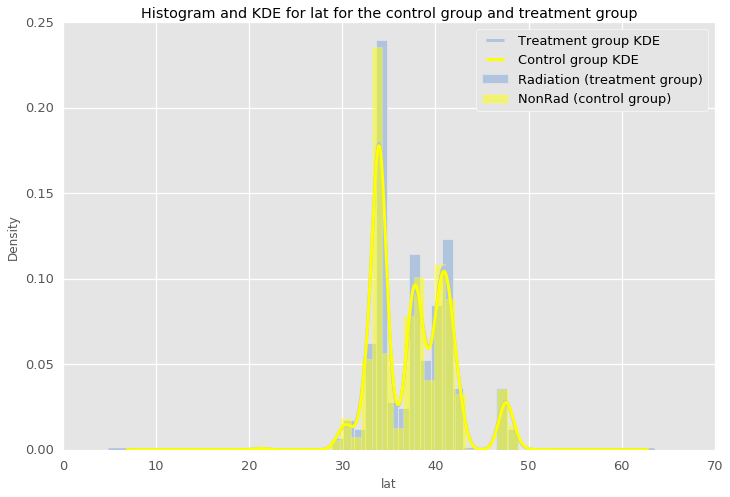

In [68]:

ax = bpost.hist(bins=25,color='LightSteelBlue',normed=True,label='Radiation (treatment group)')
bpost.plot(kind='kde',lw=3, color='LightSteelBlue', ax=ax, label='Treatment group KDE')
apost.hist(bins=25,color='yellow',normed=True,alpha=.5,label='NonRad (control group)')
apost.plot(kind='kde',lw=3, color='yellow', ax=ax, label='Control group KDE')
plt.title('Histogram and KDE for lat for the control group and treatment group')
plt.xlabel('lat')
plt.legend();

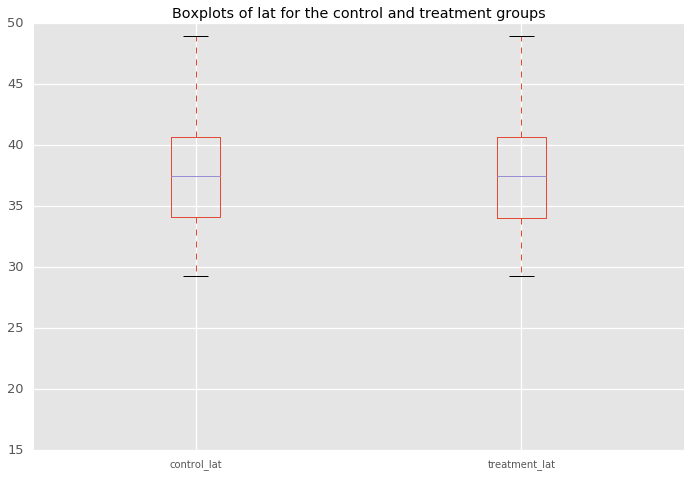

In [69]:
dflat_comp.boxplot(['control_lat','treatment_lat'],
                  return_type='axes');

plt.title('Boxplots of lat for the control and treatment groups');

## <font color='steelblue'>Let's also check how the matching performed on the categorical features</font>

Check the distributions betweent the treatment and control groups for:

* **SEX**
* **GRADE**
* **RACEIV**

In [70]:
dftreeleague['SEX_Male'].loc[treatmentindices].value_counts()

0.0    8563
1.0       5
Name: SEX_Male, dtype: int64

In [71]:
dftreeleague['SEX_Male'].loc[controlindices].value_counts()

0.0    8563
1.0       5
Name: SEX_Male, dtype: int64

## <font color='steelblue'>So the gender distribution of the treatment and control groups is actually identical.</font>

## <font color='steelblue'>Who is more likely to have insurance: Treatment (treated with rad) or Control (not treated with rad) left-sided breast cancer patients</font>

Silly question!!! Just illustrating the methodology

We will answer this question using Bayesian A/B testing.

We can use Bayesian A/B testing for all questions with a binary outcome, where either the desired event occured or not, or where  the desired feature is present or not.

In [72]:
dfbayes = dfbreast.set_index('PUBCSNUM').copy()

# the matched treatment patients insurance status; ignores the missing values
dfbayes['INSREC_PUB'][treatmentindices].value_counts()
# so the probability a treatment patient is insured is

Insured                     5156
Insured/No specifics         786
Any Medicaid                 253
Insurance status unknown      62
Uninsured                     45
Name: INSREC_PUB, dtype: int64

In [73]:
treatmentinsured = dfbayes['INSREC_PUB'][treatmentindices].value_counts()['Insured']
treatmenttotal = dfbayes['INSREC_PUB'][treatmentindices].value_counts().sum()
probtreatment = treatmentinsured/treatmenttotal
probtreatment

0.81815296731196441

In [74]:

controlinsured = dfbayes['INSREC_PUB'][controlindices].value_counts()['Insured']
controltotal = dfbayes['INSREC_PUB'][controlindices].value_counts().sum()
probcontrol = controlinsured/controltotal
probcontrol

0.7973337565465799

## <font color='steelblue'>Can use Bayesian A/B testing to see if we have enough data to see if the probability difference of having insurance between treatment and control groups for left-sided breast cancer patients is significant or not (a real effect or due to chance and small numbers).</font>

In [75]:
from IPython.display import IFrame

## <font color='steelblue'>Bayesian A/B testing</font>

An excellent explanation of Bayesian A/B testing can be found here: http://varianceexplained.org/statistics/beta_distribution_and_baseball/





In [76]:
IFrame("http://varianceexplained.org/statistics/beta_distribution_and_baseball/",
      width=800,height=400)

In [77]:
TREATMENT_INSURED = treatmentinsured
CONTROL_INSURED = controlinsured
TREATMENT_TOTAL = treatmenttotal
CONTROL_TOTAL = controltotal

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_treatment = beta(alpha_prior + TREATMENT_INSURED, beta_prior + TREATMENT_TOTAL - TREATMENT_INSURED)

posterior_control = beta(alpha_prior + CONTROL_INSURED, beta_prior + CONTROL_TOTAL - CONTROL_INSURED)


samples = 2000000

samples_posterior_treatment = posterior_treatment.rvs(samples)

samples_posterior_control = posterior_control.rvs(samples)

(samples_posterior_treatment > samples_posterior_control).mean()

0.998506

## <font color='steelblue'>So we can say that we are 99.8% certain that patients receiving radiation (as a group) are more likely than patients that do not receive radiation (as a group) to have health insurance.</font>

Shameful. If the patients  that did not have health insurance had in fact been insured, it is almost certain that their prognosis would have been better (they likely would have opted for radiation treatment). Infuriating.

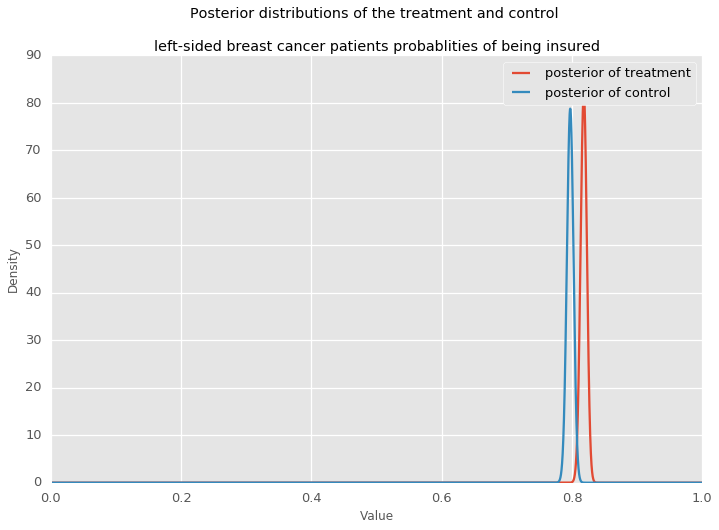

In [78]:
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_treatment.pdf(x), label='posterior of treatment')
plt.plot(x, posterior_control.pdf(x), label='posterior of control');
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("""Posterior distributions of the treatment and control \n 
left-sided breast cancer patients probablities of being insured""")
plt.legend();


In [79]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

dfbreast0 = seerhelp.make_clean_dataframe(breastfiles[0])
dfbreast1 = seerhelp.make_clean_dataframe(breastfiles[1])
dfbreast2 = seerhelp.make_clean_dataframe(breastfiles[2])
dfbreast3 = seerhelp.make_clean_dataframe(breastfiles[3])

dfbreastorig = pd.concat([dfbreast0, dfbreast1, dfbreast2,
                     dfbreast3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfbreastorig.shape)

del dfbreast0
del dfbreast1
del dfbreast2
del dfbreast3

(1448798, 141)


In [80]:
dfbreastorig = dfbreastorig.set_index('PUBCSNUM',drop=False)

In [81]:
leftfilter = dfbreastorig.LATERAL.str.contains('left origin of primary',case=False,na=False)

mask = (dfbreastorig['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfbreastorig['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfbreastorig['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfbreastorig['CSTUMSIZ'] != "Not applicable") & \
(dfbreastorig['AGE_DX'] != "Unknown age") & \
(dfbreastorig['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfbreastorig['YEAR_DX'] >= 2004) & \
(dfbreastorig['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfbreastorig['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfbreastorig['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfbreastorig['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfbreastorig['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfbreastorig['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfbreastorig['CSTUMSIZ'] != "Not applicable") & \
(dfbreastorig['YR_BRTH'] != 'Unknown year of birth') & \
(dfbreastorig['CSTUMSIZ'] != 'Not applicable') & \
(dfbreastorig['CSTUMSIZ'] != 996) & \
(dfbreastorig['CSTUMSIZ'] != 997) & \
(dfbreastorig['CSTUMSIZ'] != 998) & \
(dfbreastorig['REC_NO'] == 1) & \
(leftfilter)

In [82]:
dfbreastorig = dfbreastorig[mask]

## <font color='steelblue'>Chi-Squared Goodness-of-Fit Tests</font>

The chi-squared goodness-of-fit test is an analog of the one-way t-test for categorical variables: it tests whether the distribution of sample categorical data matches an expected distribution. Tests dealing with categorical variables are based on variable counts instead of the actual value of the variables themselves.

## <font color='steelblue'>Let's revisit the insurance question; this time for differences in the total distribution of possible values

We did not use **INSREC_PUB** as one of the features used in the matching; the distributions are different.

In [83]:
insrectreatment = dfbreastorig['INSREC_PUB'][treatmentindices].value_counts()
insrectreatment

Insured                     5156
Insured/No specifics         786
Any Medicaid                 253
Insurance status unknown      62
Uninsured                     45
Name: INSREC_PUB, dtype: int64

In [84]:
insreccontrol = dfbreastorig['INSREC_PUB'][controlindices].value_counts()
insreccontrol

Insured                     5024
Insured/No specifics         847
Any Medicaid                 311
Insurance status unknown      66
Uninsured                     53
Name: INSREC_PUB, dtype: int64

## <font color='steelblue'>The Chi-squared testing confirms the results of the Bayesian A/B testing</font>

In [85]:
stats.chisquare(insrectreatment.as_matrix(), insreccontrol.as_matrix())

Power_divergenceResult(statistic=20.127996837955539, pvalue=0.0004711651127547437)

In [86]:
stats.chisquare(insreccontrol.as_matrix(), insrectreatment.as_matrix())

Power_divergenceResult(statistic=23.090189966154387, pvalue=0.00012147947592285698)

## <font color='steelblue'>Let's also check how the matching performed on these categorical features</font>

Check the distributions betweent the treatment and control groups for:

* **GRADE**
* **RACEIV**
* **MAR_STAT**


The distributions are actually **IDENTICAL** for all the categorical features. This is a result of the one-hot-encoding procedure as well as the z-score normalization before constructing the KDTree as well as our low distance threshhold when performing the matching. An unexpected great conseuqence of the methodology.

In [87]:
gradetreatment = dfbreastorig['GRADE'].loc[treatmentindices].value_counts()
gradetreatment

Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    4403
Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               2109
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                1922
cell type not determined, not stated or not applicable                                                              109
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            25
Name: GRADE, dtype: int64

In [88]:
gradecontrol = dfbreastorig['GRADE'].loc[controlindices].value_counts()
gradecontrol

Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation    4403
Grade III; grade iii, grade 3; poorly differentiated; differentiated                                               2109
Grade I; grade i, grade 1; well differentiated; differentiated, NOS                                                1922
cell type not determined, not stated or not applicable                                                              109
Grade IV; grade iv; grade 4; undifferentaited; anaplastic                                                            25
Name: GRADE, dtype: int64

In [89]:
raceivtreatment = dfbreastorig['RACEIV'][treatmentindices].value_counts()
raceivtreatment

White                                                 8280
Black                                                  206
Chinese                                                 30
Filipino                                                28
Japanese                                                10
Other Asian, including Asian, NOS and Oriental NOS       8
Asian Indian or Pakistani, NOS                           2
Asian Indian                                             1
Other                                                    1
Vietnamese                                               1
Unknown                                                  1
Name: RACEIV, dtype: int64

In [90]:
raceivcontrol = dfbreastorig['RACEIV'][controlindices].value_counts()
raceivcontrol

White                                                 8280
Black                                                  206
Chinese                                                 30
Filipino                                                28
Japanese                                                10
Other Asian, including Asian, NOS and Oriental NOS       8
Asian Indian or Pakistani, NOS                           2
Asian Indian                                             1
Other                                                    1
Vietnamese                                               1
Unknown                                                  1
Name: RACEIV, dtype: int64

In [91]:
marstattreatment = dfbreastorig['MAR_STAT'].loc[treatmentindices].value_counts()
marstattreatment

Married (including common law)    6920
Widowed                            800
Single (never married)             425
Divorced                           346
Unknown                             73
Separated                            4
Name: MAR_STAT, dtype: int64

In [92]:
marstatcontrol = dfbreastorig['MAR_STAT'].loc[controlindices].value_counts()
marstatcontrol

Married (including common law)    6920
Widowed                            800
Single (never married)             425
Divorced                           346
Unknown                             73
Separated                            4
Name: MAR_STAT, dtype: int64

## <font color='steelblue'>Let's look at some control - treatment pairs to verify that they actually have identical values on these categorical features. </font>
Use the mapping in the dictionary ```d_c_t```

```controlindices``` are the keys, and ```treatmentindices``` are the unique values.

In [93]:
goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']

In [94]:
dfbreastorig[goodcols].loc[[controlindices[0],treatmentindices[0]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
5308418,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Jun,Alive,1940,66,2007,15,37.7749,-122.419
68654122,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Jun,Alive,1941,67,2008,11,38.4747,-121.354


In [95]:
dfbreastorig[goodcols].loc[[controlindices[1],treatmentindices[1]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
92160005,Female,Married (including common law),Black,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Oct,Alive,1944,60,2005,14,41.1232,-74.3587
11774809,Female,Married (including common law),Black,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Oct,Dead,1940,65,2005,15,41.3267,-72.8043


In [96]:
dfbreastorig[goodcols].loc[[controlindices[2],treatmentindices[2]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
70189062,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Feb,Alive,1958,52,2011,15,36.9859,-119.232
71305177,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Feb,Alive,1955,55,2011,11,36.1342,-118.86


In [97]:
dfbreastorig[goodcols].loc[[controlindices[3],treatmentindices[3]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
35848199,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Dec,Alive,1948,60,2008,13,48.033,-121.834
35810825,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Dec,Alive,1948,59,2007,10,47.0676,-122.13


In [98]:
dfbreastorig[goodcols].loc[[controlindices[334],treatmentindices[334]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
44171893,Female,Widowed,White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Jul,Alive,1940,70,2011,18,37.3337,-121.891
71291654,Female,Widowed,White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Jul,Dead,1941,70,2011,9,37.2519,-119.696


In [99]:
dfbreastorig[goodcols].loc[[controlindices[534],treatmentindices[534]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
65995759,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Oct,Alive,1955,49,2004,12,33.7175,-117.831
65993683,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Oct,Alive,1957,47,2004,14,32.7157,-117.161


In [100]:
dfbreastorig[goodcols].loc[[controlindices[53],treatmentindices[53]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
66058088,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Aug,Alive,1938,66,2005,10,38.4747,-121.354
44060327,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,"Grade I; grade i, grade 1; well differentiated...",Upper-outer quadrant of breast,Left origin of primary,Localized,8500-8549: ductal and lobular neoplasms,Aug,Alive,1940,65,2005,10,37.3337,-121.891


In [101]:
dfbreastorig[goodcols].loc[[controlindices[678],treatmentindices[678]]]

,SEX,MAR_STAT,RACEIV,NHIADE,GRADE,PRIMSITE,LATERAL,HST_STGA,HISTREC,MDXRECMP,STAT_REC,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,
93472001,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Distant,8500-8549: ductal and lobular neoplasms,Feb,Alive,1958,51,2009,22,40.7947,-74.2649
12851360,Female,Married (including common law),White,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Overlapping lesion of breast,Left origin of primary,Distant,8500-8549: ductal and lobular neoplasms,Feb,Alive,1958,51,2009,13,41.4699,-72.4732


In [102]:
import pickle

pickle.dump( d_c_t, open('d_c_to_t.p', "wb"))

# to load it back use

d_c_t_new = pickle.load( open('d_c_to_t.p', "rb"))

d_c_t_new.keys() == d_c_t.keys()



dfbreast.to_pickle('dfbreast.p')
dfbreastorig.to_pickle('dfbreastorig.p')

## <font color='steelblue'>Survival Regression</font>

While the above Kaplan-Meier implementation is useful, it only gives us an "average" view of the population. But we have specific data at patient level that we would like to use. One option is **survival regression** and the Cox Proportional Hazards model. We can use a survival regression model to compare the matched pairs' predicted individual survival curves.

Gives nonsense; see below. The predictions are not even monotonically decreasing, which is ridiculous.

In [107]:
from lifelines import AalenAdditiveFitter, CoxPHFitter


# Using Aalen's Additive model
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(resgoodpop.dropna(), 'srv_time_mon', event_col="STAT_REC_Dead")



 [-----------------100%-----------------] 34961 of 34960 complete in 9276.2 sec


<lifelines.AalenAdditiveFitter: fitted with 254535 observations, 219575 censored>

After fitting we have access to a method ```predict_survival_function``` 

In [108]:
x = resgoodpop[list(set(resgoodpop.columns).difference(set(['srv_time_mon','STAT_REC_Dead'])))]

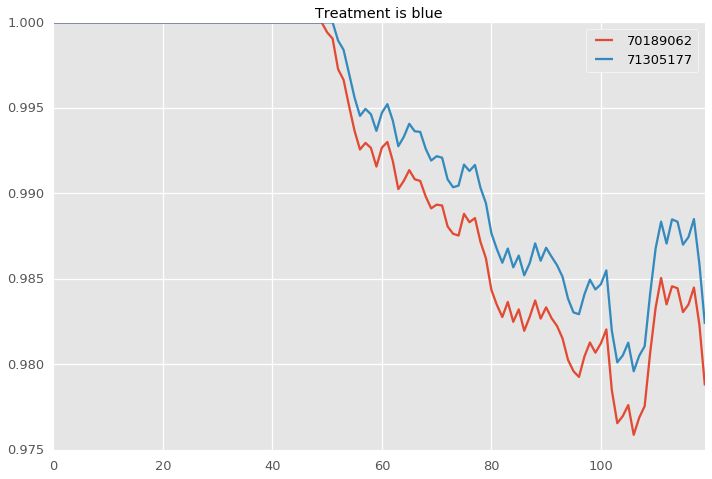

In [119]:
aaf.predict_survival_function(x.loc[[controlindices[2],treatmentindices[2]]]).plot(title='Treatment is blue');

#ax = aaf.predict_survival_function(x.loc[[controlindices[2]]]).plot(label='control');
#aaf.predict_survival_function(x.loc[[treatmentindices[2]]]).plot(label='treatment', ax=ax);
#plt.legend()

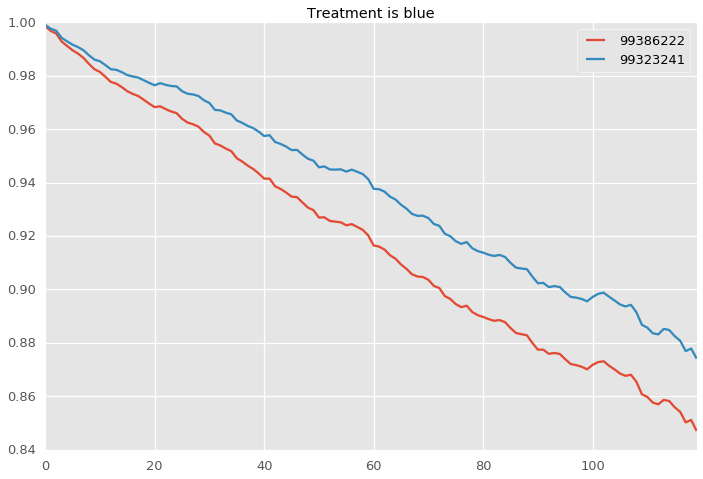

In [125]:
aaf.predict_survival_function(x.loc[[controlindices[470],treatmentindices[470]]]).plot(title='Treatment is blue');

#ax = aaf.predict_survival_function(x.loc[[controlindices[2]]]).plot(label='control');
#aaf.predict_survival_function(x.loc[[treatmentindices[2]]]).plot(label='treatment', ax=ax);
#plt.legend()

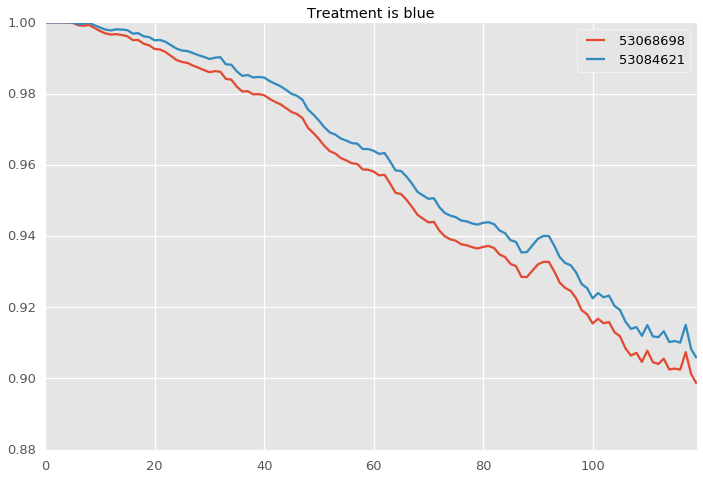

In [126]:
aaf.predict_survival_function(x.loc[[controlindices[490],treatmentindices[490]]]).plot(title='Treatment is blue');

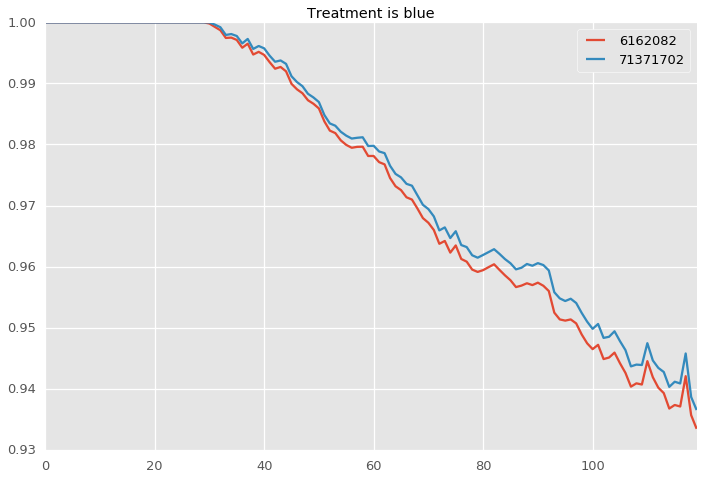

In [127]:
aaf.predict_survival_function(x.loc[[controlindices[890],treatmentindices[890]]]).plot(title='Treatment is blue');

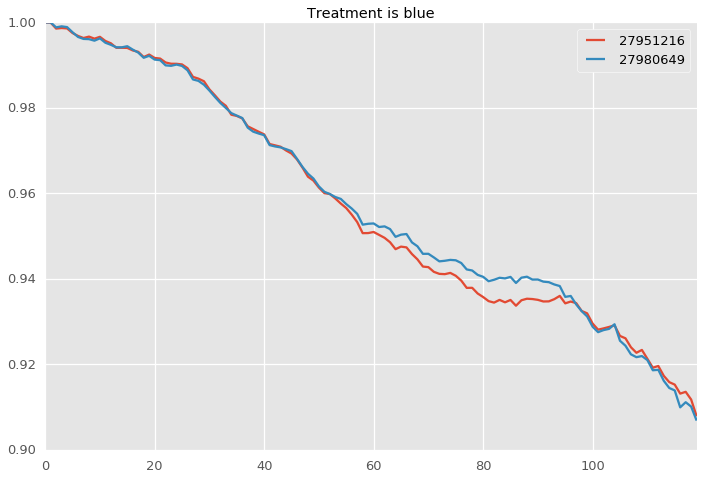

In [130]:
aaf.predict_survival_function(x.loc[[controlindices[66],treatmentindices[66]]]).plot(title='Treatment is blue');

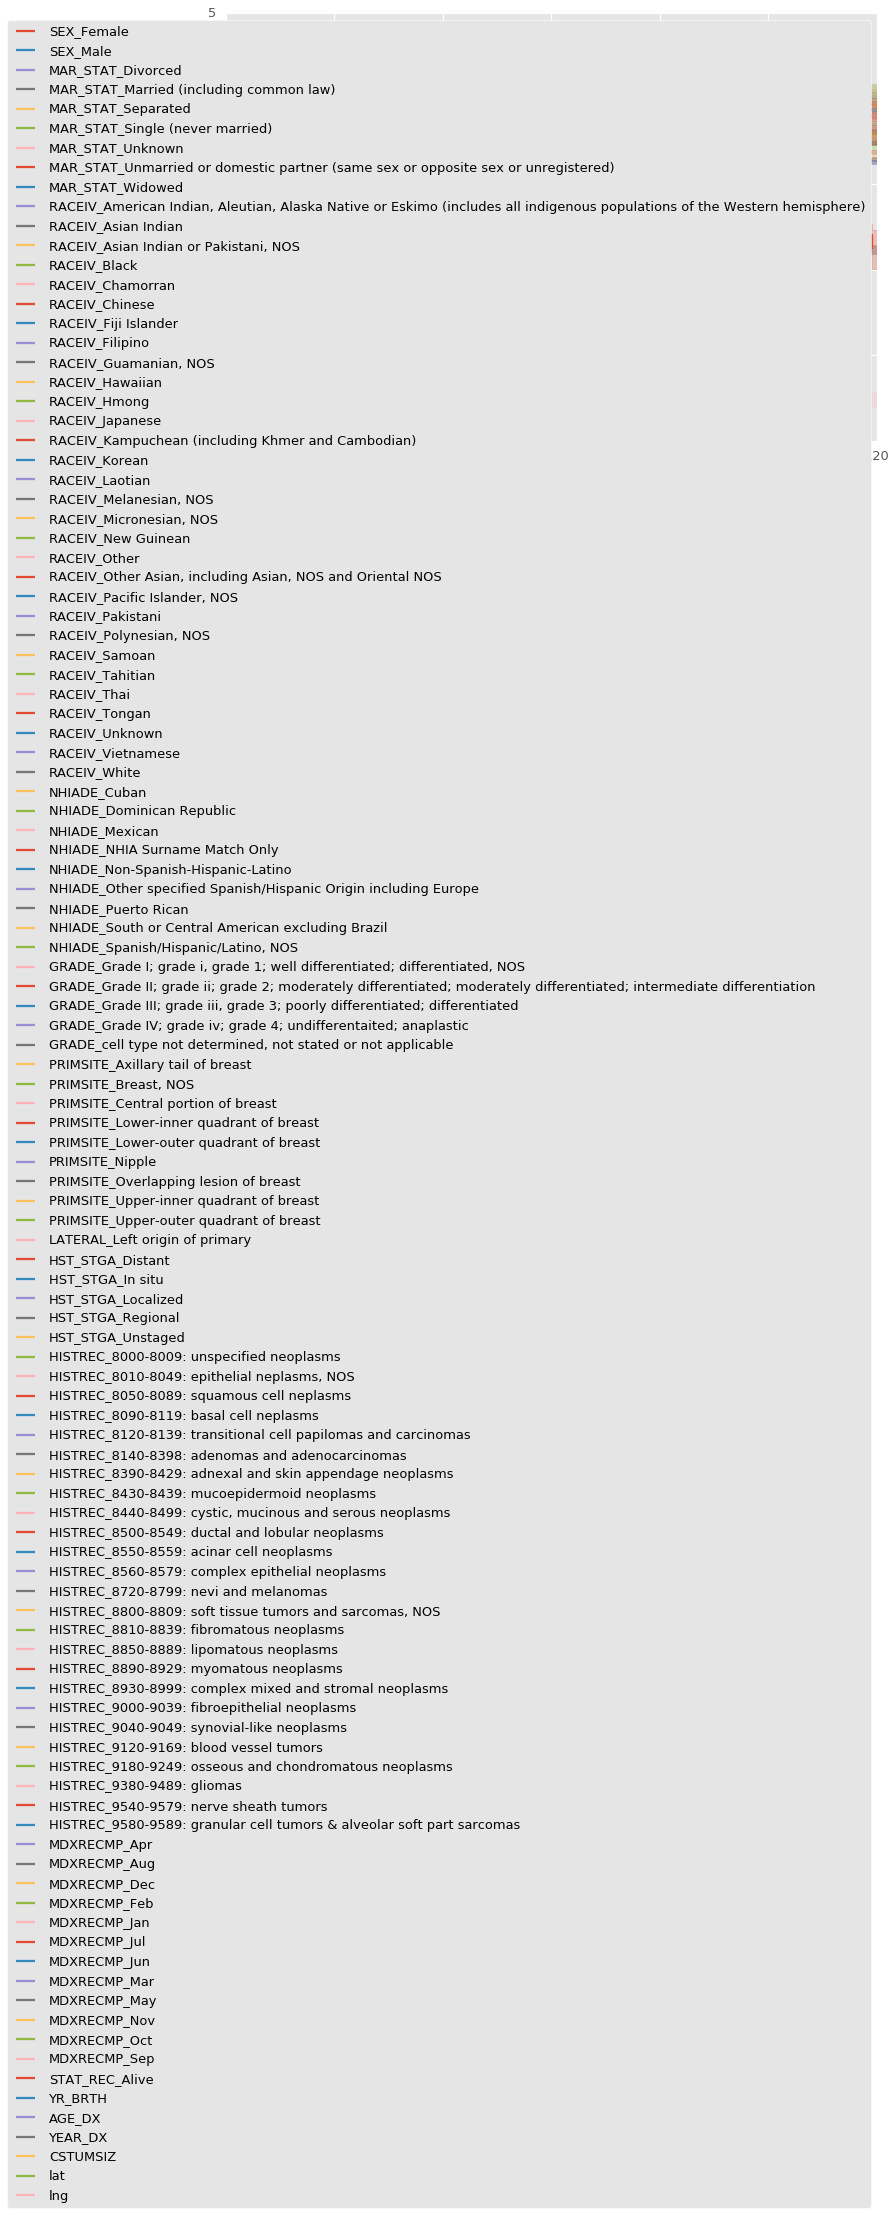

In [131]:
aaf.plot()